# IMDB Review Sentiment Classification with Word Embeddings

In [0]:
%tensorflow_version 2.x
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import models, layers

import os
import matplotlib.pyplot as plt
import numpy as np

TensorFlow 2.x selected.


In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
base_dir = os.getcwd() + '/drive/My Drive/Colab Notebooks/Deep Learning in Python/Deep Learning for Text and Sequences'
imdb_zip_path = os.path.join(base_dir, 'aclImdb.zip')

# Unzip Imdb data to current working directory
from zipfile import ZipFile

with ZipFile(imdb_zip_path, 'r') as zipObj:
  zipObj.extractall()


In [0]:
# Extract IMDB text reviews and labels (Train folder)
imdb_dir = os.getcwd() + '/aclImdb'
train_dir = os.path.join(imdb_dir, 'train')

labels = []   #Stores sentiment label
texts = []    #Stores reviews

for label_type in ['neg', 'pos']:
  dir_name = os.path.join(train_dir, label_type)
  for fname in os.listdir(dir_name):
    if fname[-4:] == '.txt':
      with open(os.path.join(dir_name, fname)) as file:
        texts.append(file.read())
      if label_type == 'neg':
        labels.append(0)
      else:
        labels.append(1)


In [0]:
print(len(labels))
print(labels[:5])
print(texts[:5])

25000
[0, 0, 0, 0, 0]
["This movie is flawed on many fronts. Like many before it, it portrays more of the mythology of the Alamo than the history. The production is poor, overall giving the impression of a welfare project for lots of actors who might have otherwise had to work on Hollywood Squares. This to me was the greatest flaw - I know the ages and general personalities of the real Alamo protagonists and the geriatric ensemble of TV actors chosen to portray them never let any hint of believability intrude.<br /><br />As a native Texan, I grew up with the mythology. I later learned more about the history. I can accept a decent production from either perspective (although I prefer more historical accuracy), but this never gave me a chance to enjoy it. Even John Wayne's or Fess Parker's versions had more life than this stolid mess, while being only slightly less accurate.<br /><br />Very disappointing - avoid it.", 'This movie is not as horrible as most Sci-Fi Channel movies. I am use

Since pretrained word embeddings will be used, we will restrict the amount of training data available since these pretrained embeddings tend to perform well on problems with little data.

In [0]:
# Tokenization of text data
maxlen = 100
training_samples = 200    # Limiting number of train samples
validation_samples = 10000
max_words = 10000

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print(len(word_index), 'unique tokens')

data = pad_sequences(sequences, maxlen=maxlen) #All sequences are length 100
labels = np.asarray(labels)
print('Data tensor shape: ', data.shape)
print('Label tensor shape: ', labels.shape)

# Shuffle data
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

# Train / Validation Splits
x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples : training_samples+validation_samples]
y_val = labels[training_samples : training_samples+validation_samples]

88582 unique tokens
Data tensor shape:  (25000, 100)
Label tensor shape:  (25000,)


Next, we will use 100 dimensional [GloVe word embeddings pretrained on 2014 English Wikipedia text (glove.6B.zip)](https://nlp.stanford.edu/projects/glove/).

In [0]:
# Import pretrained word embeddings
glove_zip_path = os.path.join(base_dir, 'glove.6B.zip')

with ZipFile(glove_zip_path, 'r') as zipObj:
  zipObj.extractall()

glove_dir = os.getcwd() + '/glove.6B'
embeddings_index = {}   #Stores GloVe word embeddings

with open('glove.6B.100d.txt') as f:
  for line in f:
    values = line.split()
    word = values[0]
    wordVec =  np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = wordVec

print('Number of word vectors: ', len(embeddings_index))

Number of word vectors:  400000


Now we need to format the word embeddings into a matrix of shape `(max_words, embedding_dim)` so it can be input into a Keras `Embedding` layer.

In [0]:
# Word embeddings matrix
embedding_dim = 100
embedding_matrix = np.zeros((max_words, embedding_dim))

for word, i in word_index.items():
  if i < max_words:
    embedding_vector = embeddings_index.get(word)
    # Words not found are left as 0 vectors
    if embedding_vector is not None:
      embedding_matrix[i] = embedding_vector

Finally lets define our model.

In [0]:
# Model definition
model = models.Sequential()
model.add(layers.Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(layers.Flatten())
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [0]:
# Load embedding_matrix and Freeze pretrained weights
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 100)          1000000   
_________________________________________________________________
flatten (Flatten)            (None, 10000)             0         
_________________________________________________________________
dense (Dense)                (None, 32)                320032    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 1,320,065
Trainable params: 320,065
Non-trainable params: 1,000,000
_________________________________________________________________


In [0]:
# Train model
model.compile(
    optimizer='rmsprop',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    x_train,
    y_train,
    batch_size=32,
    epochs=10,
    validation_data=(x_val, y_val)
)

model.save_weights(base_dir + '/pre_trained_glove_model.h5')

Train on 200 samples, validate on 10000 samples
Epoch 1/10
200/200 [==============================] - 3s 16ms/sample - loss: 1.2254 - accuracy: 0.4850 - val_loss: 0.6955 - val_accuracy: 0.4942
Epoch 2/10
200/200 [==============================] - 1s 4ms/sample - loss: 0.7290 - accuracy: 0.5800 - val_loss: 0.8869 - val_accuracy: 0.4950
Epoch 3/10
200/200 [==============================] - 1s 4ms/sample - loss: 0.5080 - accuracy: 0.8150 - val_loss: 0.9131 - val_accuracy: 0.4950
Epoch 4/10
200/200 [==============================] - 1s 4ms/sample - loss: 0.4209 - accuracy: 0.7800 - val_loss: 0.6853 - val_accuracy: 0.5633
Epoch 5/10
200/200 [==============================] - 1s 4ms/sample - loss: 0.2978 - accuracy: 0.9500 - val_loss: 0.8960 - val_accuracy: 0.4973
Epoch 6/10
200/200 [==============================] - 1s 4ms/sample - loss: 0.2235 - accuracy: 0.9650 - val_loss: 0.6932 - val_accuracy: 0.5699
Epoch 7/10
200/200 [==============================] - 1s 4ms/sample - loss: 0.1894 - ac

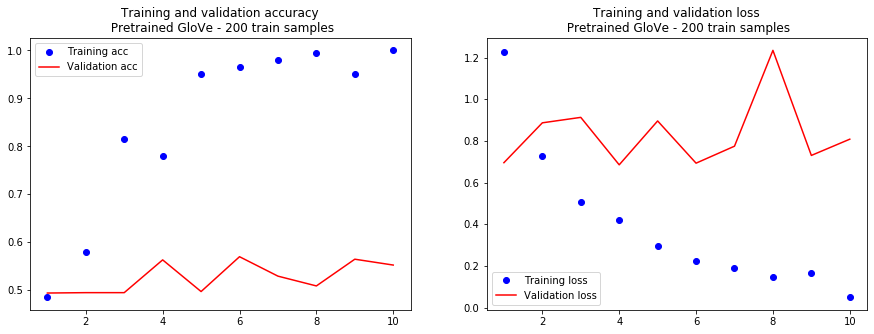

In [0]:
# Plot results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)

fig, ax = plt.subplots(1, 2, figsize=(15,5))

ax[0].plot(epochs, acc, 'bo', label='Training acc')
ax[0].plot(epochs, val_acc, 'r', label='Validation acc')
ax[0].set_title('Training and validation accuracy\n Pretrained GloVe - 200 train samples')
ax[0].legend()

ax[1].plot(epochs, loss, 'bo', label='Training loss')
ax[1].plot(epochs, val_loss, 'r', label='Validation loss')
ax[1].set_title('Training and validation loss\n Pretrained GloVe - 200 train samples')
ax[1].legend()
plt.show()

Due to the small number of training examples the model starts overfitting after only a few epochs. A validation accuracy of ~55% is achieved by this model.

Next, we will train the same model, without using the preloaded GloVe weights. This type of task-specific embedding scheme is useful when there is a lot of data available.

In [0]:
# Model definition
model = models.Sequential()
model.add(layers.Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(layers.Flatten())
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
flatten_1 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                320032    
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________


In [0]:
model.compile(
    optimizer='rmsprop',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    x_train,
    y_train,
    epochs=10,
    batch_size=32,
    validation_data=(x_val, y_val)
)

Train on 200 samples, validate on 10000 samples
Epoch 1/10
200/200 [==============================] - 1s 7ms/sample - loss: 0.6997 - accuracy: 0.4950 - val_loss: 0.6936 - val_accuracy: 0.4981
Epoch 2/10
200/200 [==============================] - 1s 4ms/sample - loss: 0.5130 - accuracy: 0.9850 - val_loss: 0.6944 - val_accuracy: 0.5160
Epoch 3/10
200/200 [==============================] - 1s 4ms/sample - loss: 0.3050 - accuracy: 0.9900 - val_loss: 0.7049 - val_accuracy: 0.5133
Epoch 4/10
200/200 [==============================] - 1s 4ms/sample - loss: 0.1487 - accuracy: 0.9950 - val_loss: 0.6970 - val_accuracy: 0.5252
Epoch 5/10
200/200 [==============================] - 1s 5ms/sample - loss: 0.0732 - accuracy: 1.0000 - val_loss: 0.7047 - val_accuracy: 0.5271
Epoch 6/10
200/200 [==============================] - 1s 4ms/sample - loss: 0.0375 - accuracy: 1.0000 - val_loss: 0.7124 - val_accuracy: 0.5183
Epoch 7/10
200/200 [==============================] - 1s 4ms/sample - loss: 0.0210 - acc

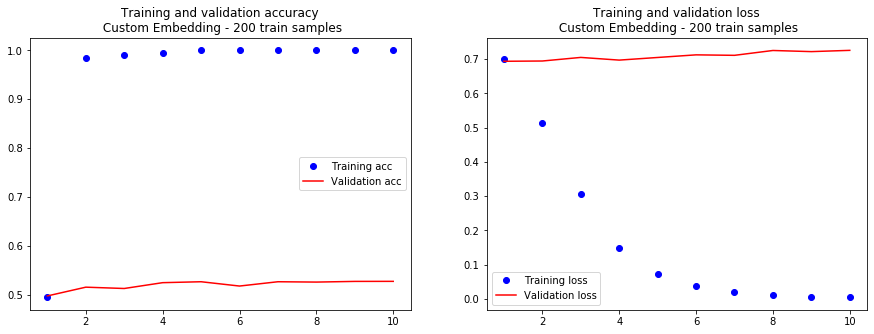

In [0]:
# Plot results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)

fig, ax = plt.subplots(1, 2, figsize=(15,5))

ax[0].plot(epochs, acc, 'bo', label='Training acc')
ax[0].plot(epochs, val_acc, 'r', label='Validation acc')
ax[0].set_title('Training and validation accuracy\n Custom Embedding - 200 train samples')
ax[0].legend()

ax[1].plot(epochs, loss, 'bo', label='Training loss')
ax[1].plot(epochs, val_loss, 'r', label='Validation loss')
ax[1].set_title('Training and validation loss\n Custom Embedding - 200 train samples')
ax[1].legend()
plt.show()

Using task specific word embeddings, we find that validation accuracy stalls at around 52%, which is worse than when using pretrained embeddings.

Now we will increase the number of training samples from 200 to 1000 to see how model performance changes with respect to the embeddings. All other model hyperparameters will be kept the same.

In [0]:
training_samples = 1000    # Increase number of train samples

# Train / Validation Splits
x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples : training_samples+validation_samples]
y_val = labels[training_samples : training_samples+validation_samples]

In [0]:
# Model definition
model = models.Sequential()
model.add(layers.Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(layers.Flatten())
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
flatten_2 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 32)                320032    
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________


In [0]:
model.compile(
    optimizer='rmsprop',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    x_train,
    y_train,
    epochs=10,
    batch_size=32,
    validation_data=(x_val, y_val)
)

Train on 1000 samples, validate on 10000 samples
Epoch 1/10
1000/1000 [==============================] - 2s 2ms/sample - loss: 0.6923 - accuracy: 0.5360 - val_loss: 0.6843 - val_accuracy: 0.5808
Epoch 2/10
1000/1000 [==============================] - 1s 1ms/sample - loss: 0.4149 - accuracy: 0.9740 - val_loss: 0.6568 - val_accuracy: 0.6103
Epoch 3/10
1000/1000 [==============================] - 1s 1ms/sample - loss: 0.1018 - accuracy: 0.9980 - val_loss: 0.6445 - val_accuracy: 0.6364
Epoch 4/10
1000/1000 [==============================] - 1s 1ms/sample - loss: 0.0171 - accuracy: 1.0000 - val_loss: 0.6630 - val_accuracy: 0.6430
Epoch 5/10
1000/1000 [==============================] - 1s 1ms/sample - loss: 0.0031 - accuracy: 1.0000 - val_loss: 0.6847 - val_accuracy: 0.6482
Epoch 6/10
1000/1000 [==============================] - 1s 1ms/sample - loss: 5.7166e-04 - accuracy: 1.0000 - val_loss: 0.7141 - val_accuracy: 0.6522
Epoch 7/10
1000/1000 [==============================] - 1s 1ms/sample -

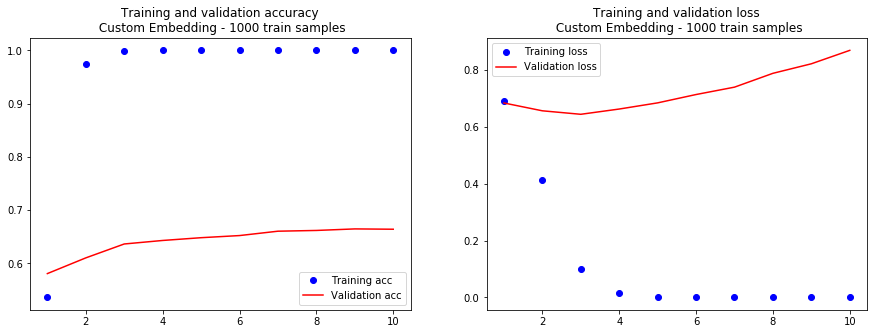

In [0]:
# Plot results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)

fig, ax = plt.subplots(1, 2, figsize=(15,5))

ax[0].plot(epochs, acc, 'bo', label='Training acc')
ax[0].plot(epochs, val_acc, 'r', label='Validation acc')
ax[0].set_title('Training and validation accuracy\n Custom Embedding - 1000 train samples')
ax[0].legend()

ax[1].plot(epochs, loss, 'bo', label='Training loss')
ax[1].plot(epochs, val_loss, 'r', label='Validation loss')
ax[1].set_title('Training and validation loss\n Custom Embedding - 1000 train samples')
ax[1].legend()
plt.show()

Using 1000 training samples instead of 200, the model now produces a validation accuracy of ~65%, which is more than a 10% increase.

In [0]:
# Load & Tokenize test set
test_dir = os.path.join(imdb_dir, 'test')

labels=[]
texts=[]

for label_type in ['neg','pos']:
  dir_name = os.path.join(test_dir, label_type)
  for fname in sorted(os.listdir(dir_name)):
    if fname[-4:] == '.txt':
      with open(os.path.join(dir_name, fname)) as file:
        texts.append(file.read())
      if label_type == 'neg':
        labels.append(0)
      else:
        labels.append(1)

sequences = tokenizer.texts_to_sequences(texts)
x_test = pad_sequences(sequences, maxlen=maxlen)
y_test = np.asarray(labels)

# Evaluate model on test set
model.evaluate(x_test,y_test)

25000/25000 [==============================] - 2s 86us/sample - loss: 0.8875 - accuracy: 0.6568


[0.8874712087440491, 0.6568]

Evaluating the model on the test set, it achieves an accuracy of 66% which is comparable to the validation set.

If we were to continue improving upon this model, the following next steps would be considered:
- Increasing the number of training samples
- Control overfitting with a dropout layer, or weight decay
- Increasing the number of training epochs